In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys
import os
import datetime
import time
import math
import requests
import warnings


from sklearn.metrics import mean_squared_error
from tabulate import tabulate
from scipy.spatial.distance import pdist, cdist, squareform
from IPython.display import display, clear_output

%load_ext autoreload
%autoreload 2

In [37]:
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

def denormalize(arr, min, max):
    return arr * (max - min) + min

In [52]:
x = np.loadtxt('lorenz.txt')

x_max = x.max()
x_min = x.min()
x = normalize(x)

In [71]:
class TSProcessor:
    def __init__(self, points_in_template, max_template_spread):
        self.vector_data = None
        self.time_series = None
        self.predictions = None
        
        templates = (np.repeat(0, max_template_spread ** (points_in_template - 1)).reshape(-1, 1), )
        
        for i in range(1, points_in_template):
            col = (np.repeat(np.arange(1, max_template_spread + 1, dtype = int), max_template_spread ** (points_in_template - (i + 1))) + templates[i - 1][:: max_template_spread ** (points_in_template - i)]).reshape(-1, 1)
            templates += (col, )
        
        self.templates = np.hstack(templates) # координаты шаблонов от начала
        
        self.template_shapes = self.templates[:, 1:] - self.templates[:, :-1] # расстояния между зубцами шаблона
        
        self.x_dim = 0
        self.y_dim = 0
        self.z_dim = 0
        
    
    def fit(self, time_series):
        self.predictions = None
        self.time_series = time_series
        
        self.x_dim, self.y_dim, self.z_dim = self.templates.shape[0], time_series.size - self.templates[0][-1], self.templates.shape[1]
        
        # self.x_dim, self.y_dim, self.z_dim  = 1000 897 4
        
        self.vector_data = np.full(shape = (self.x_dim, self.y_dim, self.z_dim), fill_value = np.inf, dtype = np.float)
        
        for i in range(self.x_dim):
            template_data = time_series[self.templates[i] + np.arange(time_series.size - self.templates[i][-1])[:, None]]
            self.vector_data[i, :template_data.shape[0]] = time_series[self.templates[i] + np.arange(time_series.size - self.templates[i][-1])[:, None]]

            
    
    def forecast(self, steps, eps, noise_amp):
        original_size = self.time_series.size
        time_series = self.time_series.copy()
        vector_data = np.hstack((self.vector_data.copy(), np.full((self.x_dim, steps, self.z_dim), fill_value = np.inf)))

        forecast_vectors = time_series[np.cumsum(-self.template_shapes[:, ::-1], axis = 1)[:, ::-1]]

        distance_matrix = ((vector_data[:, :, 0] - np.repeat(forecast_vectors[:, 0], self.y_dim + steps).reshape(-1, self.y_dim + steps)) ** 2 +
                           (vector_data[:, :, 1] - np.repeat(forecast_vectors[:, 1], self.y_dim + steps).reshape(-1, self.y_dim + steps)) ** 2 +
                           (vector_data[:, :, 2] - np.repeat(forecast_vectors[:, 2], self.y_dim + steps).reshape(-1, self.y_dim + steps)) ** 2) ** 0.5
        
        time_series = np.resize(self.time_series, original_size + steps)
        
        self.predictions = np.full(steps, fill_value = np.nan)
        
        for i in range(steps):
            good_vectors = vector_data[distance_matrix < eps]
            points = good_vectors[:, -1]
            
            values, counts = np.unique(points, return_counts = True)

            final_forecasted_point = values[counts.argmax()] + random.uniform(-noise_amp, noise_amp)
            self.predictions[i] = final_forecasted_point
            time_series[original_size + i] = final_forecasted_point

            last_vectors = time_series[:original_size + 1 + i][np.hstack((np.cumsum(-self.template_shapes[:, ::-1], axis = 1)[:, ::-1] - 1, np.repeat(-1, self.x_dim).reshape(-1, 1)))]

            vector_data[:, self.y_dim - steps + i, :] = last_vectors

            forecast_vectors = time_series[:original_size + i + 1][np.cumsum(-self.template_shapes[:, ::-1], axis = 1)[:, ::-1]]

            distance_matrix = ((vector_data[:, :, 0] - np.repeat(forecast_vectors[:, 0], self.y_dim + steps).reshape(-1, self.y_dim + steps)) ** 2 +
                               (vector_data[:, :, 1] - np.repeat(forecast_vectors[:, 1], self.y_dim + steps).reshape(-1, self.y_dim + steps)) ** 2 +
                               (vector_data[:, :, 2] - np.repeat(forecast_vectors[:, 2], self.y_dim + steps).reshape(-1, self.y_dim + steps)) ** 2) ** 0.5
    
        return self

In [93]:
split = 900
eps = 0.01
steps = 100

tsp = TSProcessor(4, 10)
tsp.fit(x[:split]) # переданы первые 900 элементов ряда

tsp.forecast(steps, eps, 0)
preds = tsp.predictions

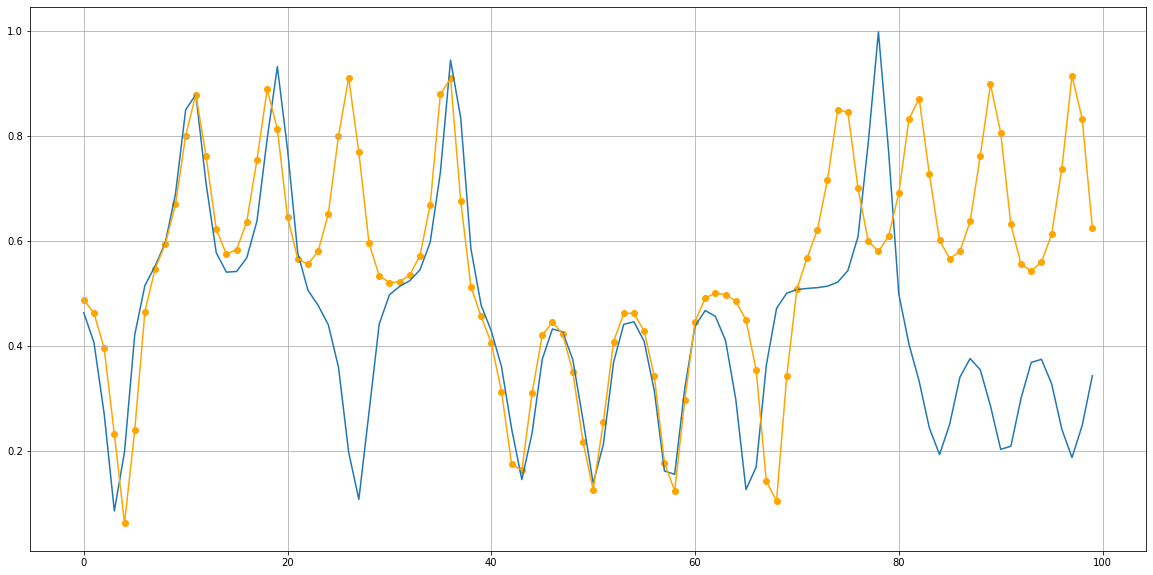

In [94]:
plt.figure(figsize = [20, 10])
plt.grid()
plt.plot(x[split:split + 100])

plt.scatter(range(preds.size), preds, c = 'orange')
plt.plot(range(preds.size), preds, c = 'orange')

NameError: name 'forecast_sets' is not defined

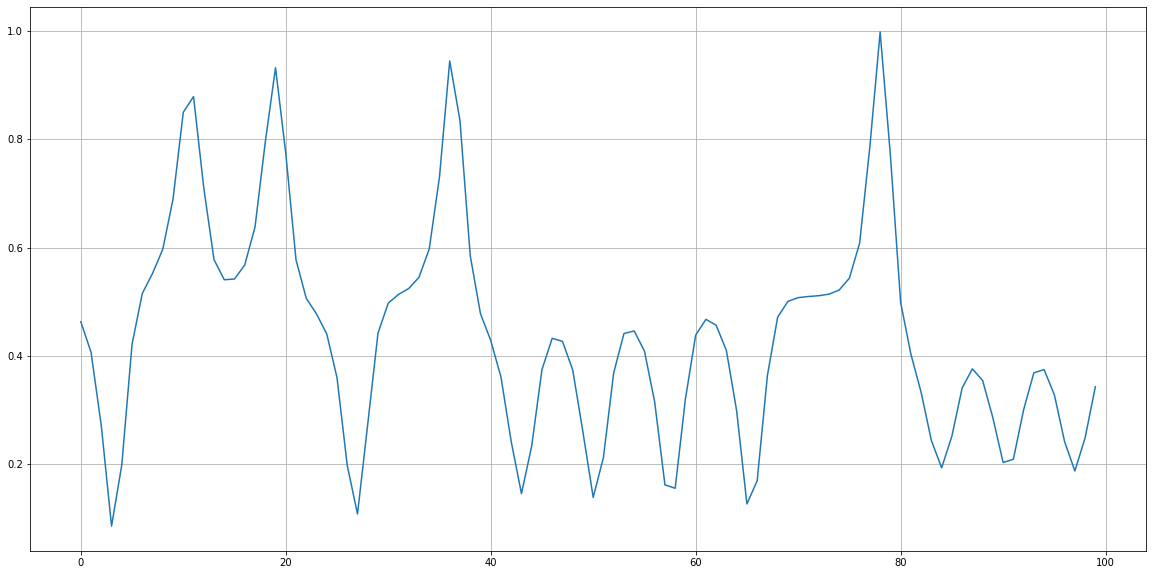

In [95]:
plt.figure(figsize = [20, 10])
plt.grid()
plt.plot(x[split:split + 100])

for i in range(len(forecast_sets)):
    plt.scatter(np.repeat(i, len(forecast_sets[i])), forecast_sets[i], c = 'orange')
    plt.plot([i, i], [min(forecast_sets[i]), max(forecast_sets[i])], c = 'orange')

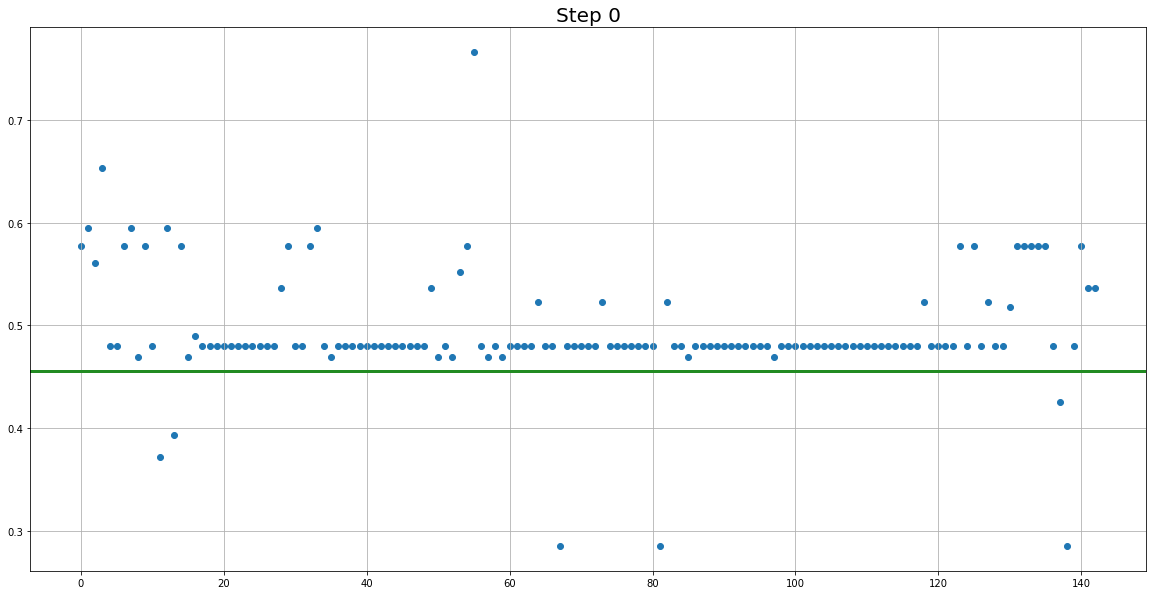

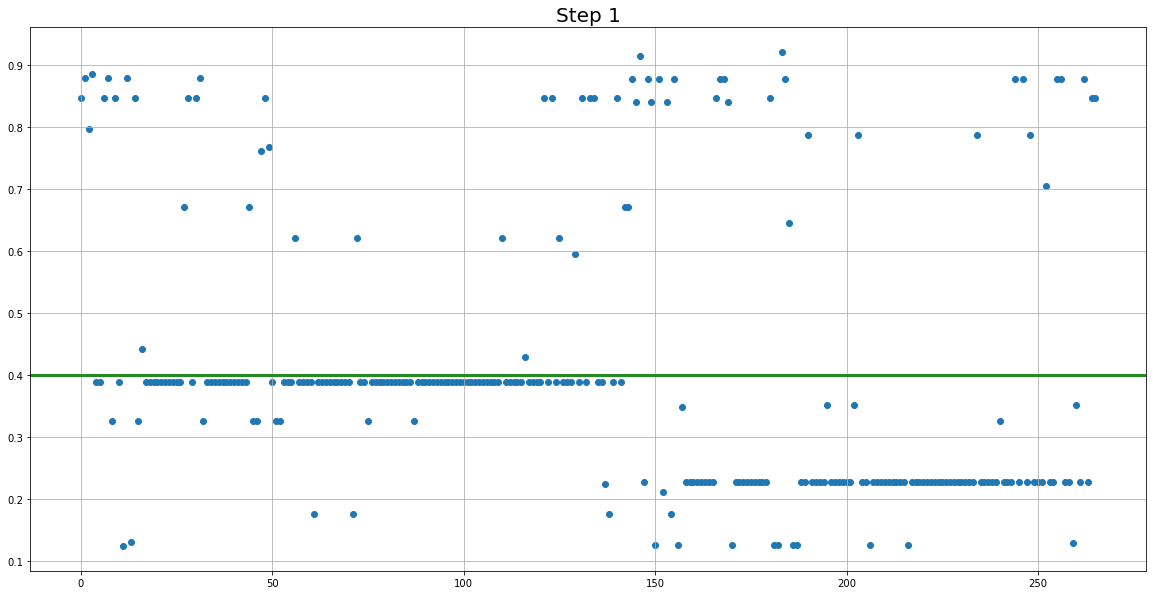

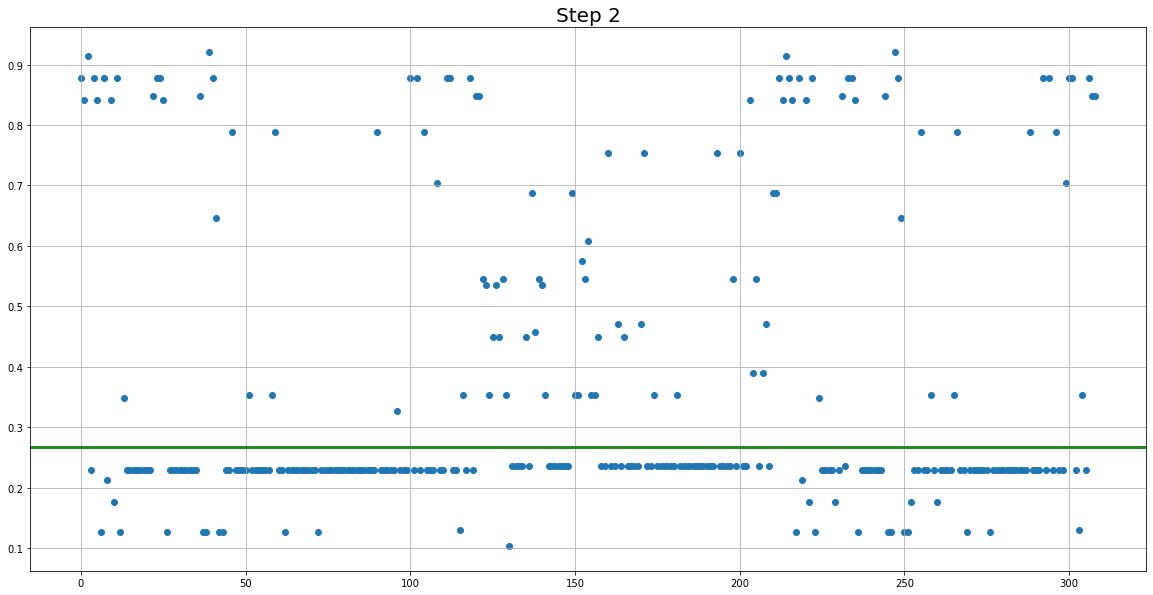

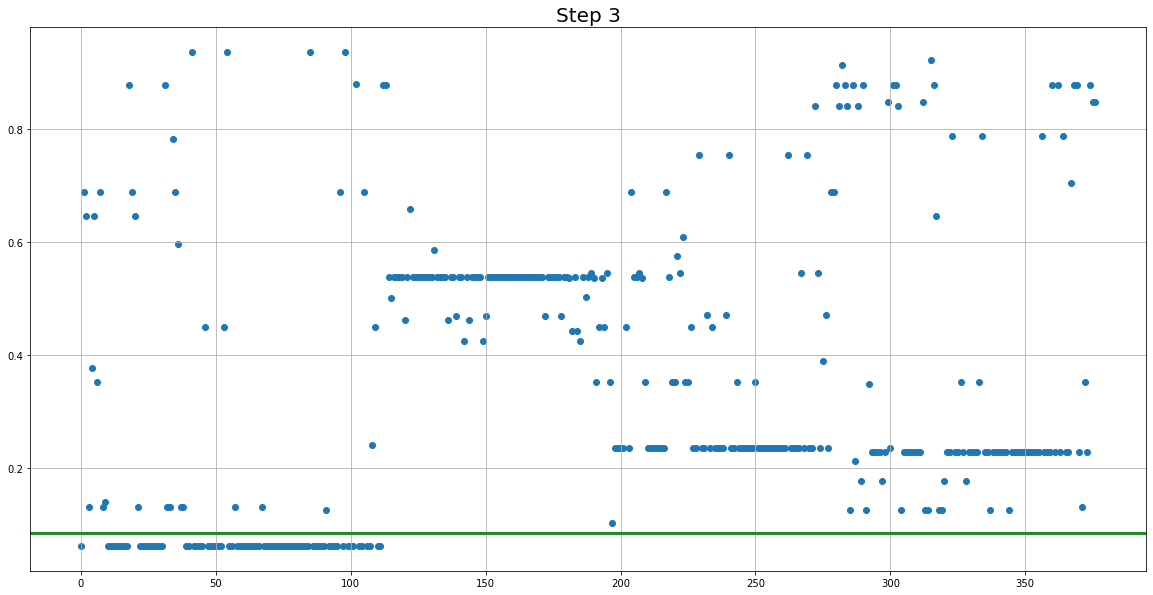

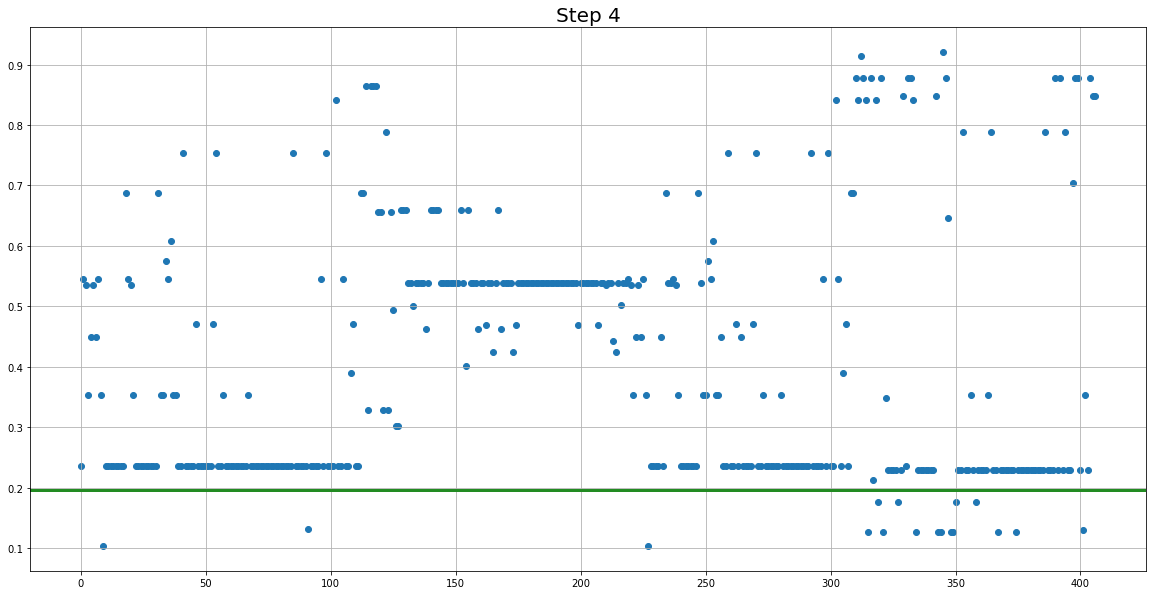

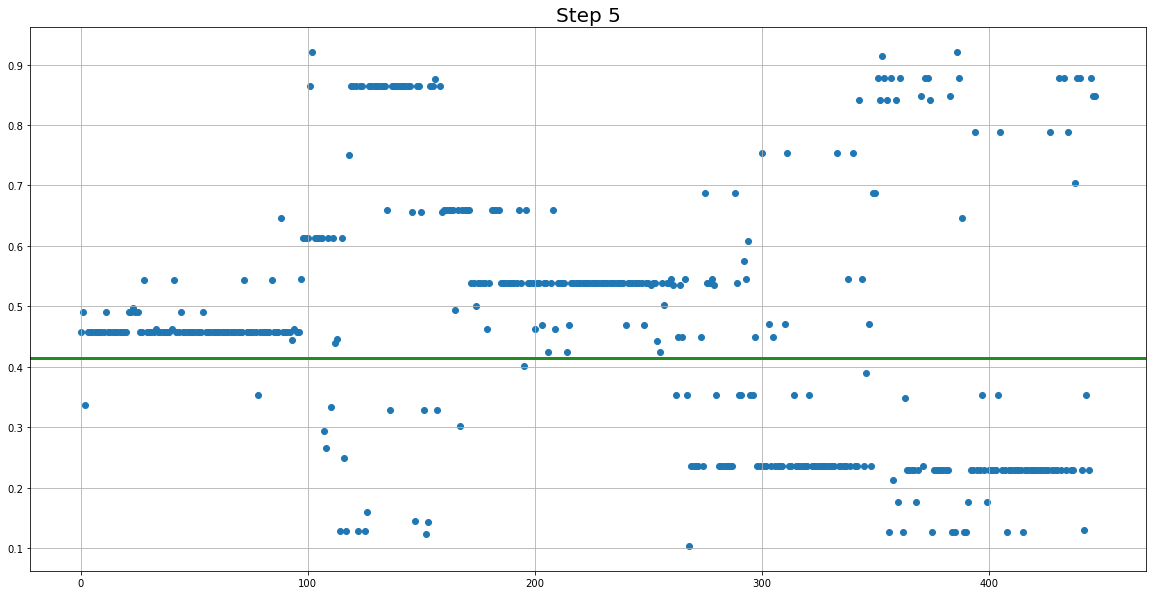

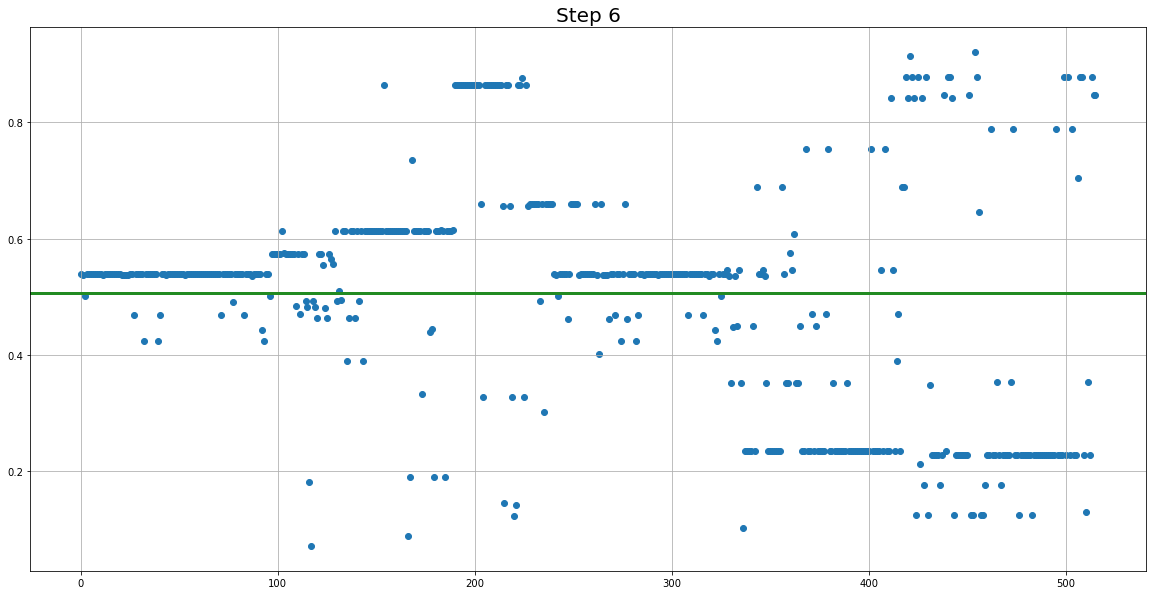

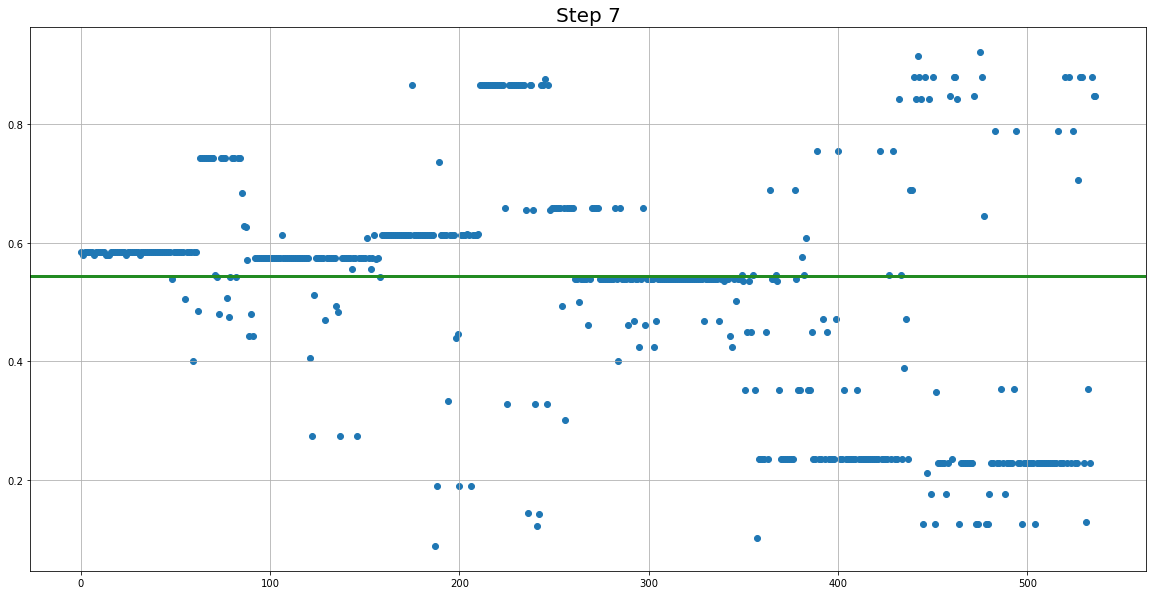

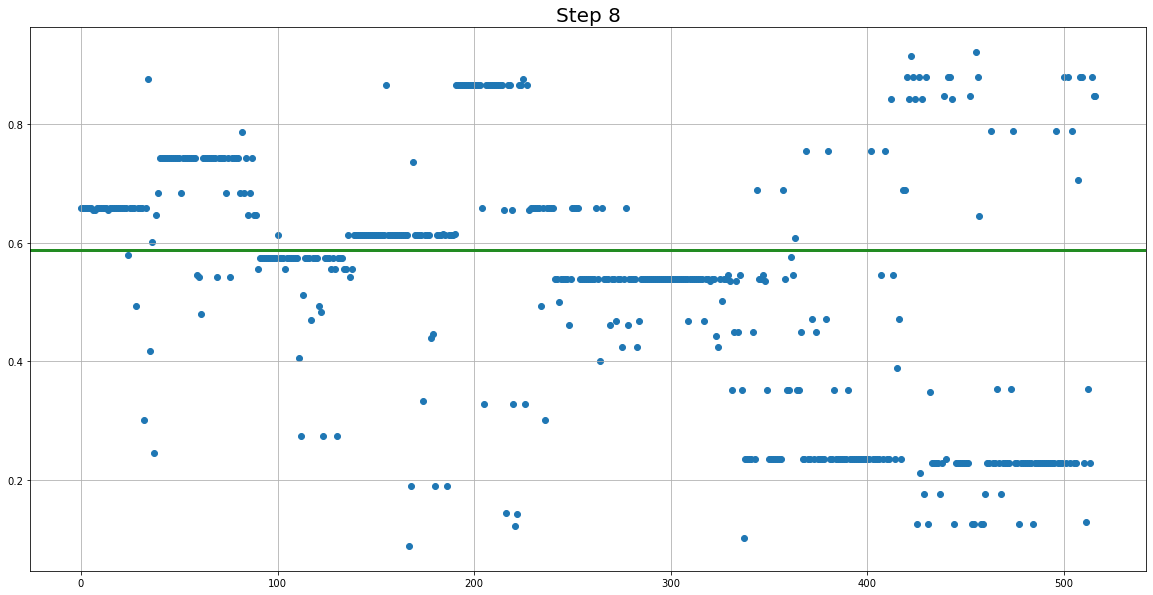

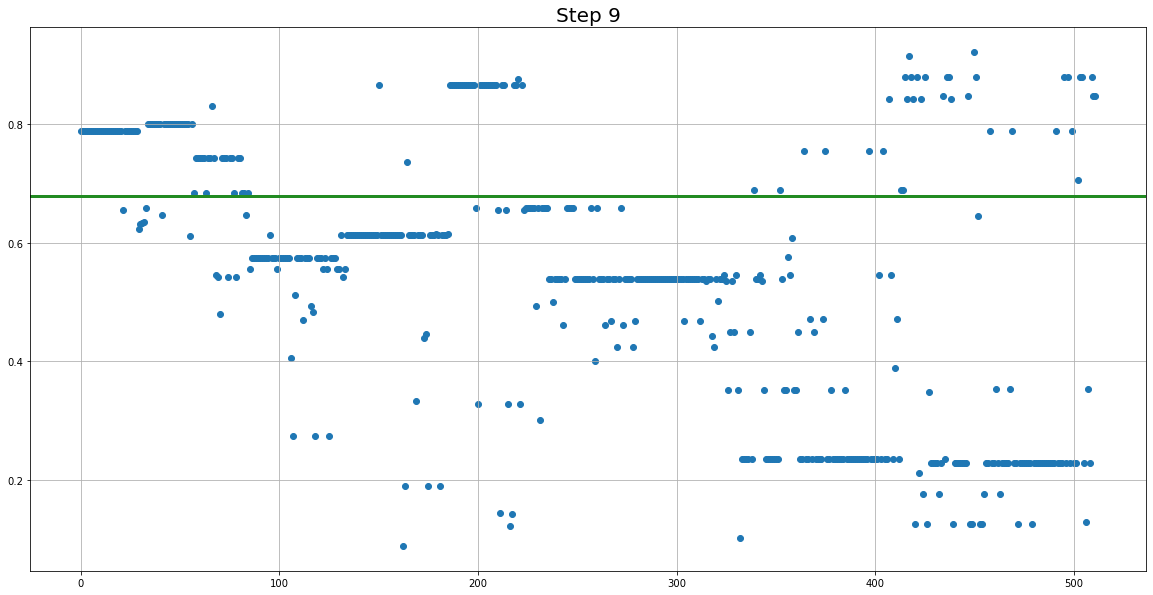

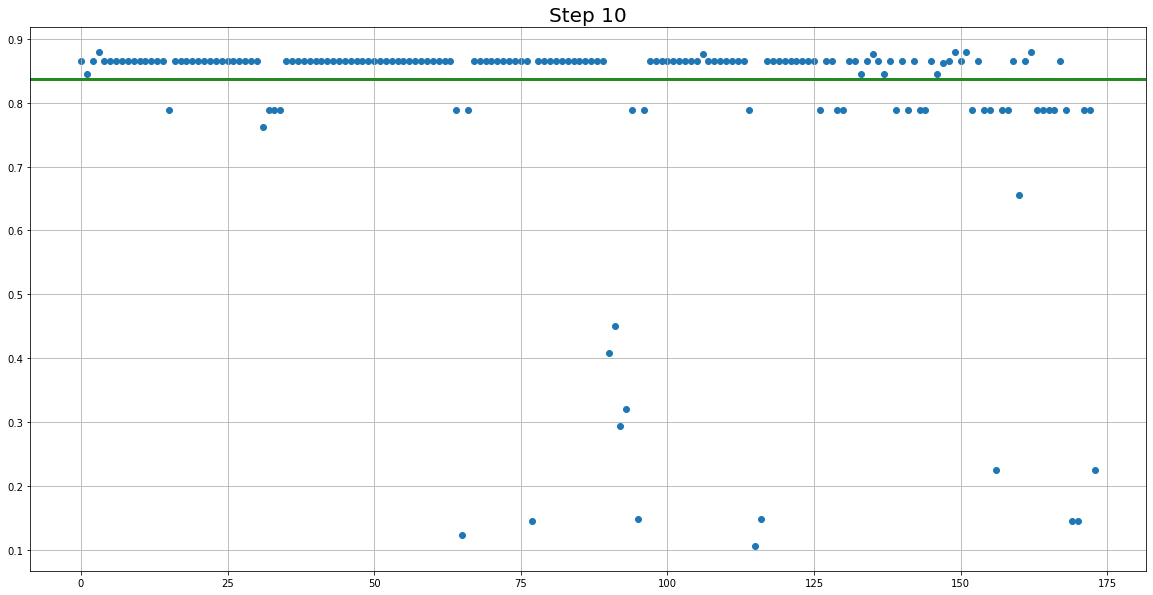

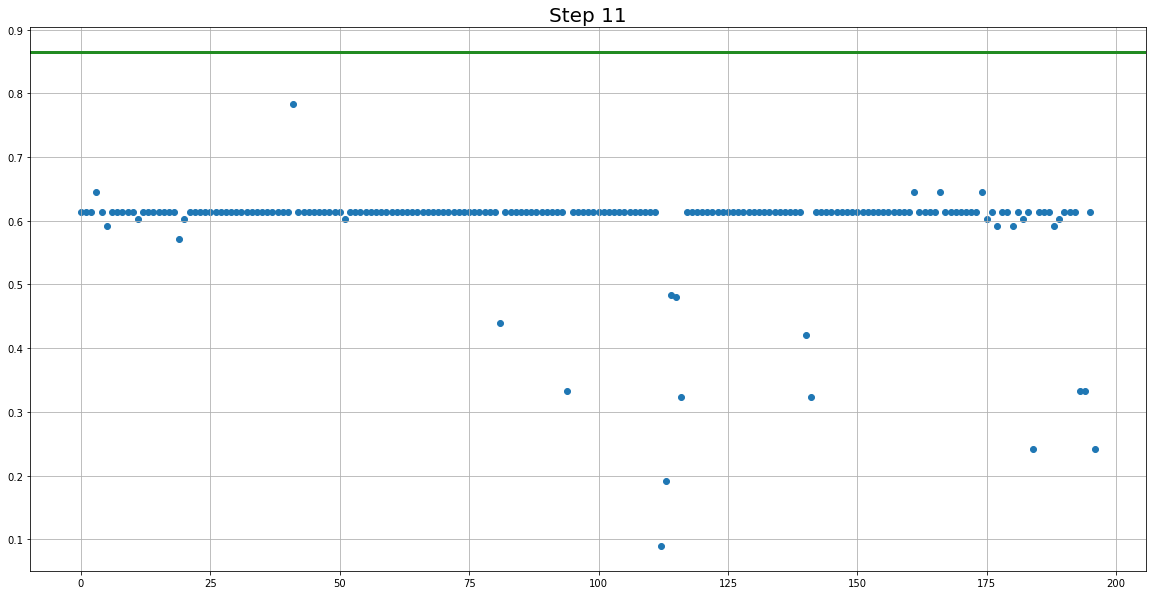

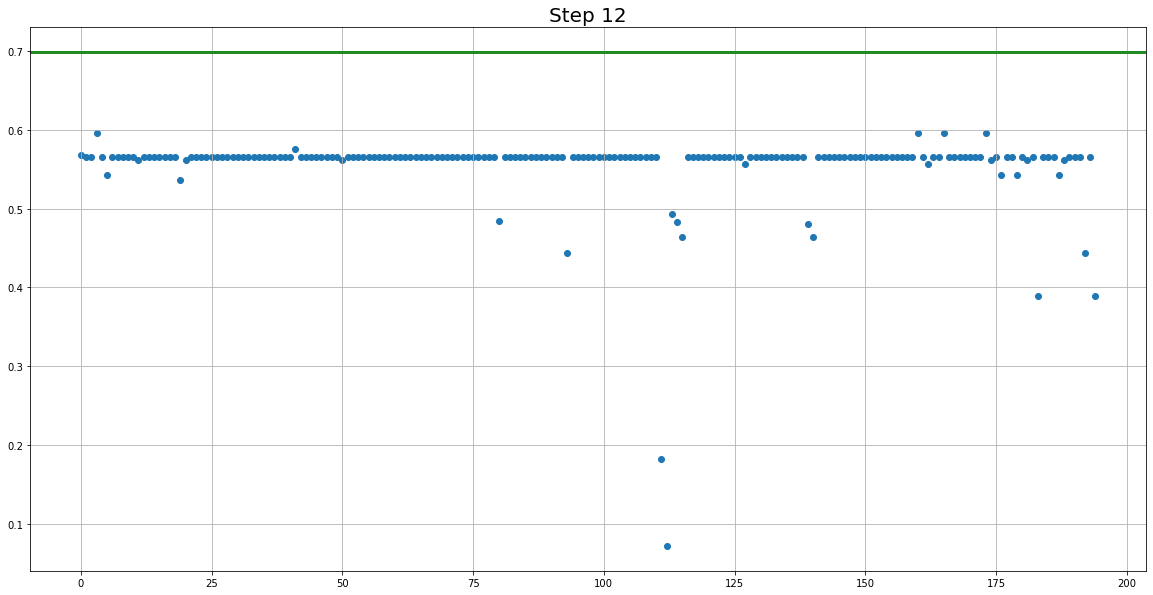

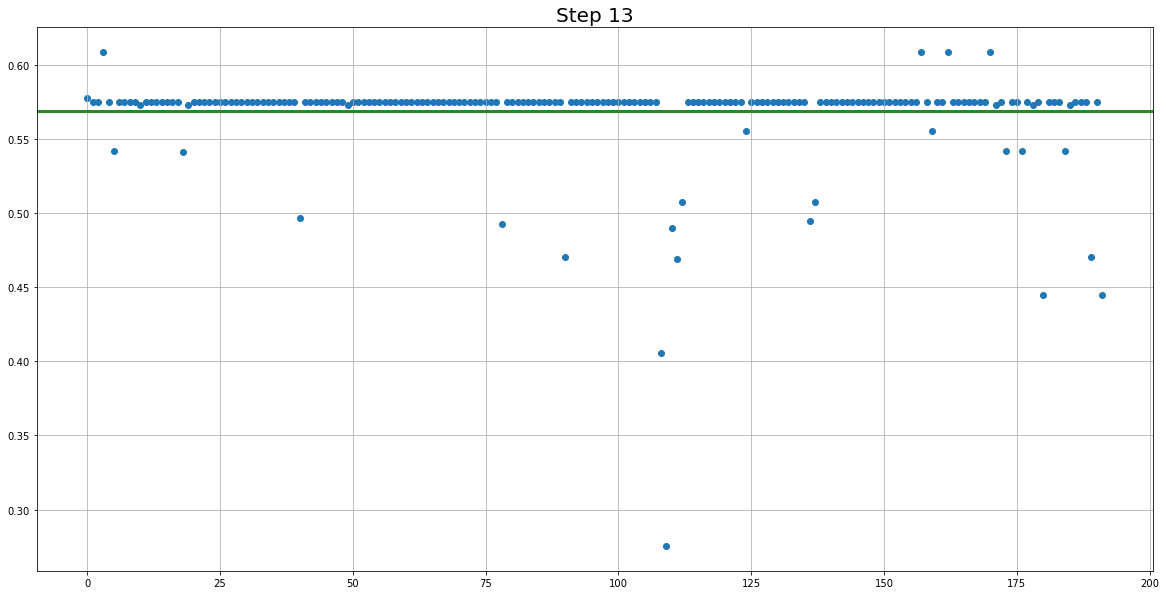

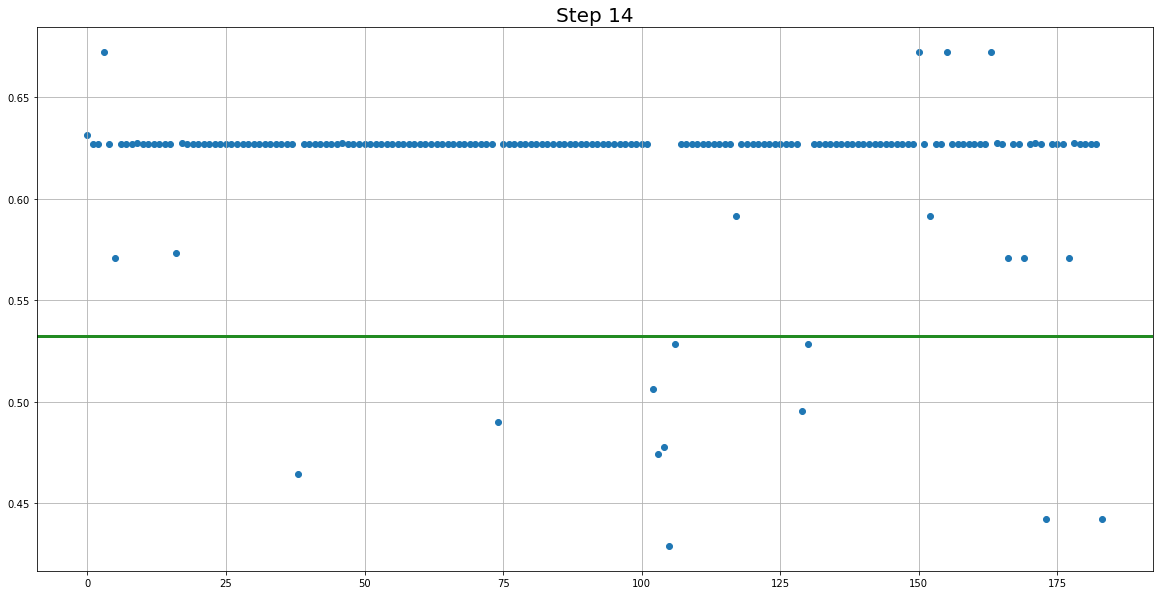

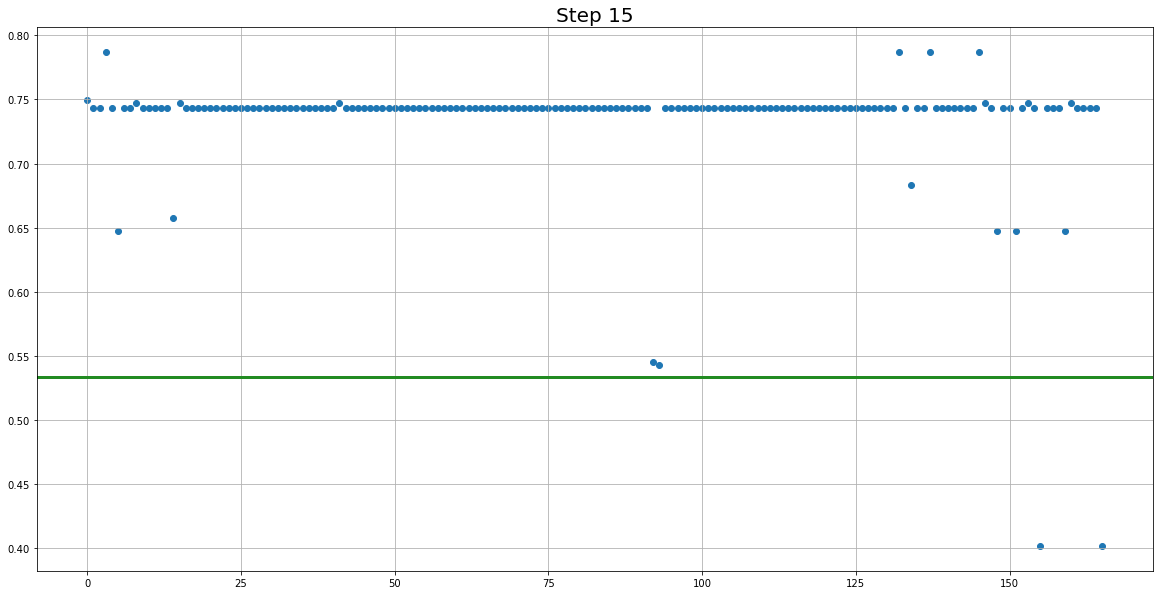

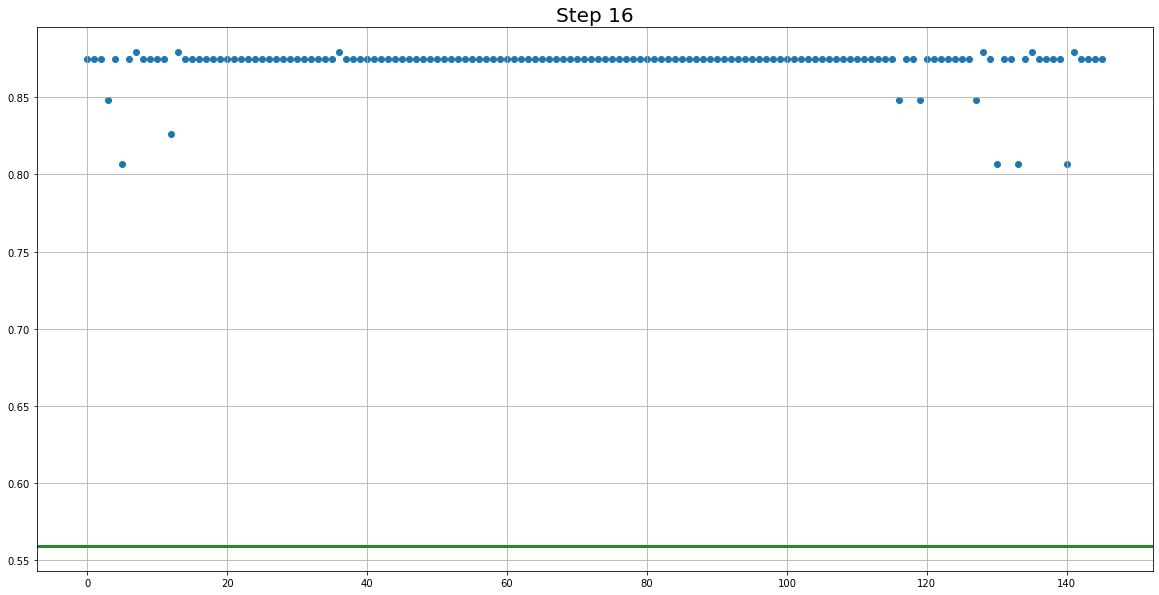

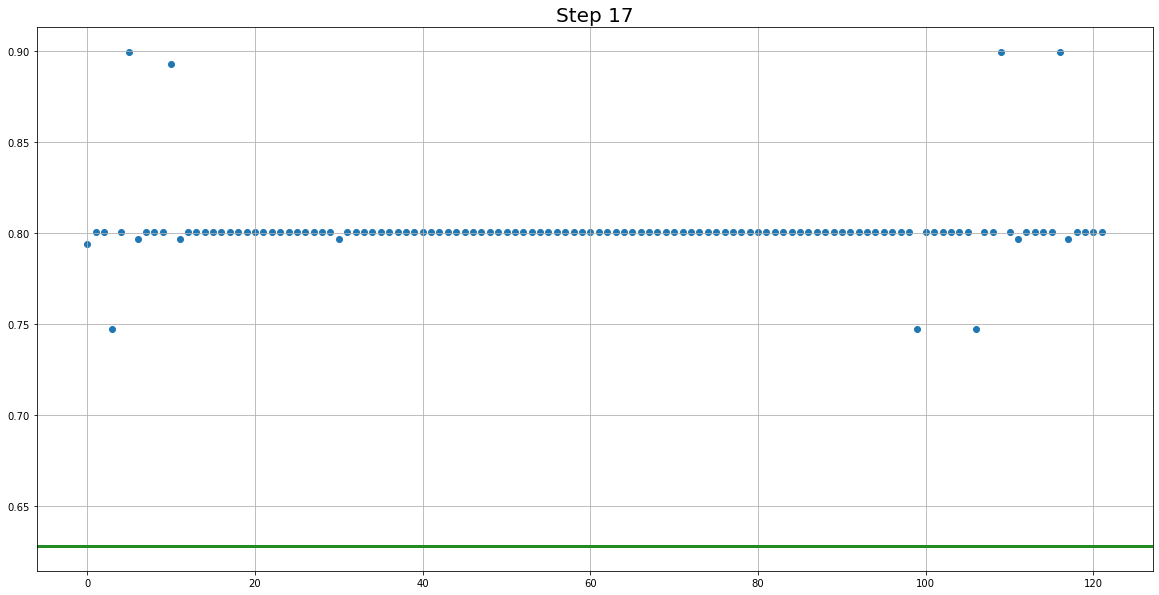

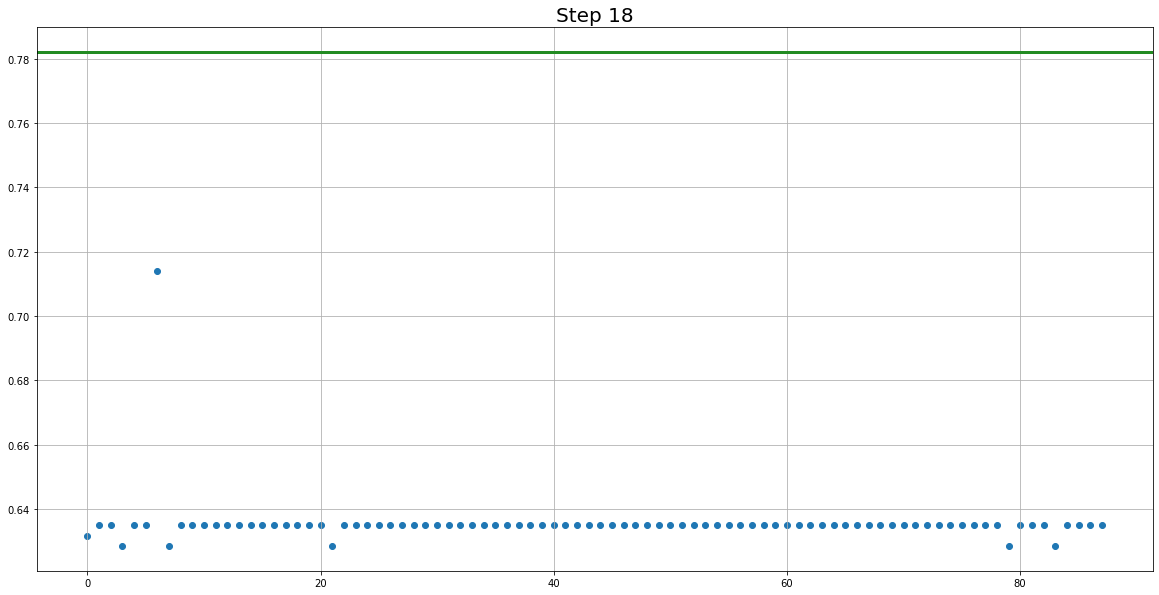

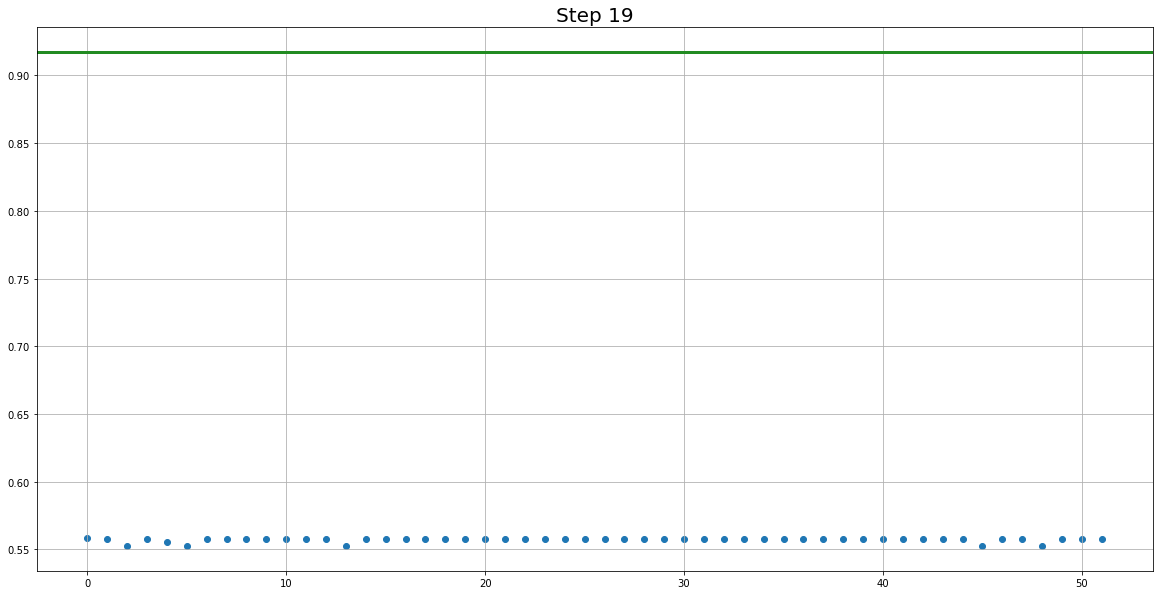

In [102]:
for i in range(len(forecast_sets)):
    plt.figure(figsize = [20, 10])
    plt.grid()
    plt.title('Step %d' % i, fontsize = 20)
    
    plt.scatter(range(len(forecast_sets[i])), forecast_sets[i])
    plt.axhline(x[split + i], linewidth = 3, c = 'forestgreen')
    
    plt.show()

In [48]:
a = np.array([1,2,4,5,6,10])

print(a[[1,2]])

#print(a[:, None])

[2 4]


In [106]:
a = np.arange(5)
a

array([0, 1, 2, 3, 4])

In [100]:
b = np.array([2, 2, 2])


In [107]:
np.exp(a)


array([ 1.        ,  2.71828183,  7.3890561 , 20.08553692, 54.59815003])